In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
df = pd.read_csv("/Users/tahsin/Documents/kaggle/ab_test/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Exploratory Analysis 

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [75]:
# check if null values exist
df.isna().sum(axis = 0)

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [76]:
# check each group and their landing page 
df['user_id'].groupby(by=[df['group'],df['landing_page']]).count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: user_id, dtype: int64

In [77]:
# remove the wrong grouped data
df = df[((df['group'] == 'treatment')&(df['landing_page'] == 'new_page'))|((df['group'] == 'control')&(df['landing_page'] == 'old_page'))]
df['user_id'].groupby(by=[df['group'],df['landing_page']]).count()

group      landing_page
control    old_page        145274
treatment  new_page        145311
Name: user_id, dtype: int64

In [78]:
# check if there are any duplicated users
duplicate_user = df['user_id'].value_counts()
duplicated_user = duplicate_user[duplicate_user>1].count()
print("more than 1 entry (user):",duplicated_user)

more than 1 entry (user): 1


In [79]:
# remove the duplicated users
df = df[~df['user_id'].isin(duplicate_user[duplicate_user>1].index)]
print("New len:",len(df))

New len: 290583


## Sampling the data set

In [80]:
# split the control and treatment group
df_control = df[df['group']=='control']
df_treatment = df[df['group']=='treatment']

In [81]:
# sample the control and treat group
control_sample = df_control.sample(n = 5000, random_state =22)
treatment_sample = df_treatment.sample(n = 5000, random_state = 22)

In [82]:
# make one dataframe from the sample groups
df_ab = pd.concat([control_sample, treatment_sample], axis=0)
df_ab.reset_index(inplace= True, drop =True )
df_ab.head(5)

,user_id,timestamp,group,landing_page,converted
0,864622,2017-01-07 19:35:55.115584,control,old_page,0
1,931017,2017-01-20 22:24:11.980654,control,old_page,0
2,822759,2017-01-10 19:00:45.471182,control,old_page,0
3,715765,2017-01-19 23:16:23.269389,control,old_page,0
4,666686,2017-01-23 00:08:30.152180,control,old_page,0


In [83]:
# check the new dataframe with sampled values
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       10000 non-null  int64 
 1   timestamp     10000 non-null  object
 2   group         10000 non-null  object
 3   landing_page  10000 non-null  object
 4   converted     10000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 390.8+ KB


(0.0, 0.14)

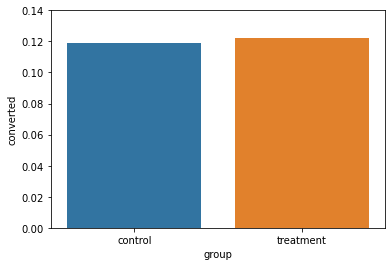

In [84]:
# check conversion rate by group of the new sampled data
sns.barplot(x=df_ab['group'], y =df_ab['converted'], ci =False)
plt.ylim(0, 0.14)

## Hypothesis testing 

In [85]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [86]:
# split the groups and keep only the Y column
df_control_res = df_ab[df_ab["group"]=="control"]
df_control_res = df_control_res["converted"]
df_treatment_res = df_ab[df_ab["group"]=="treatment"]
df_treatment_res = df_treatment_res["converted"]


In [87]:
# count number of successes and number of observations for each group
n_control = df_control_res.count()
n_treatment = df_treatment_res.count()
successes = [df_control_res.sum(),df_treatment_res.sum()]
n = [n_control, n_treatment]
print(successes)
print(n)

[594, 611]
[5000, 5000]


In [88]:
# compute p-value and confidence interval
z_stat, pval = proportions_ztest(successes, nobs = n)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=n, alpha=0.05)

print("p-value:", pval)
print("Confiden interval - 95% control group: ",lower_con, upper_con)
print("Confiden interval - 95% treatment group: ",lower_treat, upper_treat)

p-value: 0.6015305766159301
Confiden interval - 95% control group:  0.10983173250488006 0.12776826749511994
Confiden interval - 95% treatment group:  0.11312186827642595 0.13127813172357405


### Decision